In [7]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import utils
from torchvision.models import list_models

from scripts.cat_vs_dog_helpers import train, evalf, experiment_pipeline, plot_results

## Load Data

In [2]:
data = torch.load("cat_vs_dog_data.pt")
labels = torch.load("cat_vs_dog_labels.pt").reshape((-1,1))

In [3]:
data.shape

torch.Size([25000, 3, 100, 100])

- data is transformed into 100x100 rgb images

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Pretrained models in Pytorch

In [5]:
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

Models:
- Alexnet
- VGG19BN
- InceptionV3
- DenseNet
- Resnet
- MobileNetV3

## AlexNet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:16<00:00, 33.56it/s]


Epoch-1:
Train Accuracy: 80.52571105957031
Train Loss: 0.31978386640548706


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:14<00:00, 36.60it/s]


Epoch-2:
Train Accuracy: 82.27428436279297
Train Loss: 0.42150095105171204


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:16<00:00, 33.67it/s]


Epoch-3:
Train Accuracy: 82.54285430908203
Train Loss: 0.4414190351963043


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:15<00:00, 36.11it/s]


Epoch-4:
Train Accuracy: 82.97142791748047
Train Loss: 0.20825281739234924


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:15<00:00, 34.78it/s]


Epoch-5:
Train Accuracy: 82.605712890625
Train Loss: 0.5412672758102417


100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:23<00:00, 322.75it/s]


Test Accuracy: 86.6933364868164


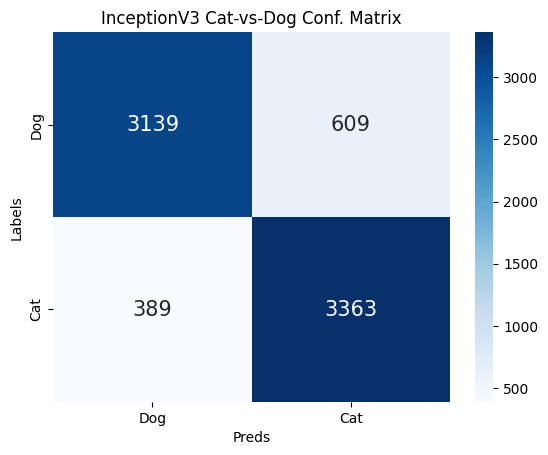

In [6]:
class AlexNetBackboned(nn.Module):
    def __init__(self):
        super(AlexNetBackboned, self).__init__()
        # Load pretrained alexnet
        self.alexnet = torch.hub.load("pytorch/vision:v0.10.0", "alexnet", weights="DEFAULT")

        # freezing the alexnet parameters
        for param in self.alexnet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.alexnet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 227

batch_size = 32

net = AlexNetBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

alexnet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

alexnet_evals["experiment_time"] = time.time() - start

torch.save(alexnet_evals, "catvsdog-results/alexnet_results.pt")
torch.save(net, "alexnet_model.pt")

## VGG19-BN

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-1:
Train Accuracy: 94.93142700195312
Train Loss: 0.125993013381958


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.34it/s]


Epoch-2:
Train Accuracy: 95.81714630126953
Train Loss: 0.10424001514911652


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-3:
Train Accuracy: 96.01714324951172
Train Loss: 0.07620304822921753


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-4:
Train Accuracy: 95.96000671386719
Train Loss: 0.535494863986969


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-5:
Train Accuracy: 96.182861328125
Train Loss: 0.02921486459672451


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:00<00:00, 62.14it/s]


Test Accuracy: 97.46666717529297


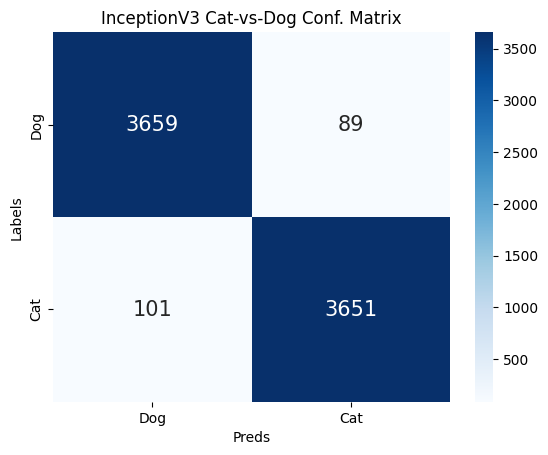

In [7]:
class VGG19BNBackboned(nn.Module):
    def __init__(self):
        super(VGG19BNBackboned, self).__init__()
        # Load pretrained vgg19_bn
        self.vgg19_bn = torch.hub.load("pytorch/vision:v0.10.0", "vgg19_bn", weights="DEFAULT")

        # freezing the vgg parameters
        for param in self.vgg19_bn.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.vgg19_bn(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = VGG19BNBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

vgg_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

vgg_evals["experiment_time"] = time.time() - start

torch.save(vgg_evals, "catvsdog-results/vgg19_bn_results.pt")
torch.save(net, "vgg19_bn_model.pt")

## InceptionV3

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:20<00:00,  3.90it/s]


Epoch-1:
Train Accuracy: 95.0971450805664
Train Loss: 0.09827088564634323


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:19<00:00,  3.91it/s]


Epoch-2:
Train Accuracy: 95.5142822265625
Train Loss: 0.0852339044213295


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:19<00:00,  3.91it/s]


Epoch-3:
Train Accuracy: 95.75428009033203
Train Loss: 0.11506588011980057


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:19<00:00,  3.91it/s]


Epoch-4:
Train Accuracy: 95.72571563720703
Train Loss: 0.08534152805805206


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:20<00:00,  3.91it/s]


Epoch-5:
Train Accuracy: 96.04571533203125
Train Loss: 0.0967671126127243


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:03<00:00, 60.52it/s]


Test Accuracy: 97.43999481201172


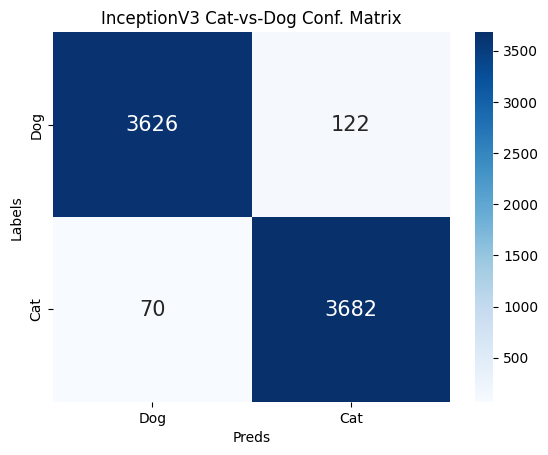

In [8]:
class InceptionV3Backboned(nn.Module):
    def __init__(self):
        super(InceptionV3Backboned, self).__init__()
        # Load pretrained InceptionV3
        self.inceptionv3 = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", weights="DEFAULT")
        
        # some other thing related with inception model
        self.inceptionv3.aux_logits = False

        # freezing the inception parameters
        for param in self.inceptionv3.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.inceptionv3(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 229

batch_size = 32

net = VGG19BNBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

inception_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

inception_evals["experiment_time"] = time.time() - start

torch.save(inception_evals, "catvsdog-results/inception_v3_results.pt")
torch.save(net, "inception_v3_model.pt")

## DenseNet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:07<00:00,  4.31it/s]


Epoch-1:
Train Accuracy: 96.33714294433594
Train Loss: 0.09941528737545013


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-2:
Train Accuracy: 97.1885757446289
Train Loss: 0.07671940326690674


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-3:
Train Accuracy: 97.71428680419922
Train Loss: 0.00747972447425127


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-4:
Train Accuracy: 97.83428192138672
Train Loss: 0.3504624664783478


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-5:
Train Accuracy: 97.9142837524414
Train Loss: 0.045989327132701874


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [04:57<00:00, 25.20it/s]


Test Accuracy: 98.21333312988281


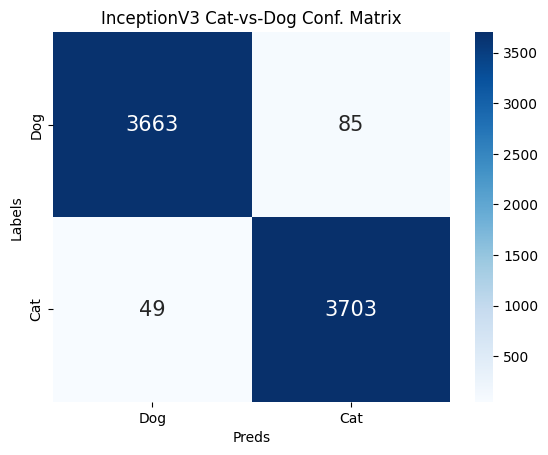

In [9]:
class DenseNetBackBoned(nn.Module):
    def __init__(self):
        super(DenseNetBackBoned, self).__init__()
        # Load pretrained densenet
        self.densenet = torch.hub.load("pytorch/vision:v0.10.0", "densenet161", weights="DEFAULT")

        # freezing the densenet parameters
        for param in self.densenet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.densenet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = DenseNetBackBoned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

densenet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

densenet_evals["experiment_time"] = time.time() - start

torch.save(densenet_evals, "catvsdog-results/densenet161_results.pt")
torch.save(net, "densenet161_model.pt")

## Resnet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00,  9.97it/s]


Epoch-1:
Train Accuracy: 94.80000305175781
Train Loss: 0.028575439006090164


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.05it/s]


Epoch-2:
Train Accuracy: 96.04000091552734
Train Loss: 0.08933383971452713


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00,  9.98it/s]


Epoch-3:
Train Accuracy: 96.38285827636719
Train Loss: 0.161708801984787


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.03it/s]


Epoch-4:
Train Accuracy: 96.61714172363281
Train Loss: 0.03539170324802399


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.03it/s]


Epoch-5:
Train Accuracy: 96.75428771972656
Train Loss: 0.15667609870433807


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:40<00:00, 74.43it/s]


Test Accuracy: 97.91999816894531


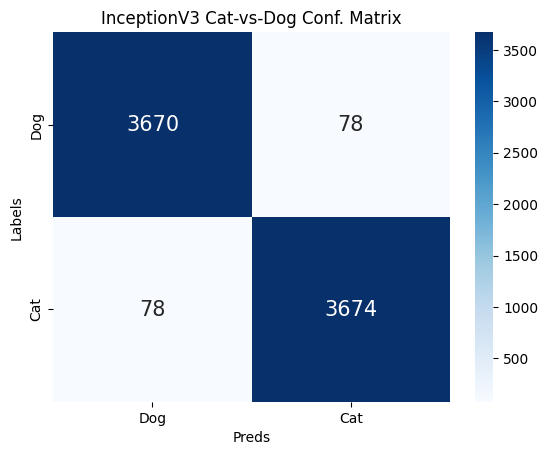

In [10]:
class ResnetBackBoned(nn.Module):
    def __init__(self):
        super(ResnetBackBoned, self).__init__()
        # Load pretrained resnet
        self.resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", weights="DEFAULT")

        # freezing the resnet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.resnet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = ResnetBackBoned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

resnet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

resnet_evals["experiment_time"] = time.time() - start

torch.save(resnet_evals, "catvsdog-results/resnet50_results.pt")
torch.save(net, "resnet50_model.pt")

## MobileNetV3

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:24<00:00, 22.22it/s]


Epoch-1:
Train Accuracy: 90.55428314208984
Train Loss: 0.17493821680545807


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:22<00:00, 23.87it/s]


Epoch-2:
Train Accuracy: 92.0
Train Loss: 0.06901271641254425


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:21<00:00, 24.91it/s]


Epoch-3:
Train Accuracy: 92.57714080810547
Train Loss: 0.15860077738761902


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:21<00:00, 25.63it/s]


Epoch-4:
Train Accuracy: 92.79999542236328
Train Loss: 0.13072387874126434


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:20<00:00, 26.79it/s]


Epoch-5:
Train Accuracy: 93.18285369873047
Train Loss: 0.4126129746437073


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:40<00:00, 74.49it/s]


Test Accuracy: 95.0


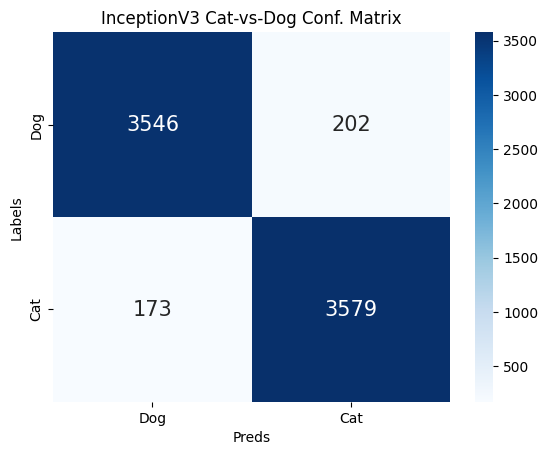

In [11]:
class MobileNetV3Backboned(nn.Module):
    def __init__(self):
        super(MobileNetV3Backboned, self).__init__()
        # Load pretrained mobilenet
        self.mobilenet = torch.hub.load("pytorch/vision:v0.10.0", "mobilenet_v3_large", weights="DEFAULT")## VGG19-BN

        # freezing the mobilenet parameters
        for param in self.mobilenet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.mobilenet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = MobileNetV3Backboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

mobilenet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

mobilenet_evals["experiment_time"] = time.time() - start

torch.save(mobilenet_evals, "catvsdog-results/mobilenet_v3_large_results.pt")
torch.save(net, "mobilenet_v3_large_model.pt")

# Results

In [4]:
file_names = ['alexnet_results.pt',
             'densenet161_results.pt',
             'inception_v3_results.pt',
             'mobilenet_v3_large_results.pt',
             'resnet50_results.pt',
             'vgg19_bn_results.pt']

model_names = [f.split("_results")[0] for f in file_names]

In [5]:
model_train_accs = []
model_test_accs = []
model_train_losses = []
experiment_times = []
true_labels = []
model_preds = []

# gather the info
for f in file_names:
    model_result = torch.load(f"catvsdog-results/{f}")
    
    model_train_accs.append(model_result["train_accuracies"])
    model_test_accs.append(model_result["accuracy"])
    model_train_losses.append(model_result["train_losses"])
    experiment_times.append(model_result["experiment_time"])
    true_labels = model_result["true_labels"]
    model_preds.append(model_result["model_preds"])

## Train Accuracies and Losses

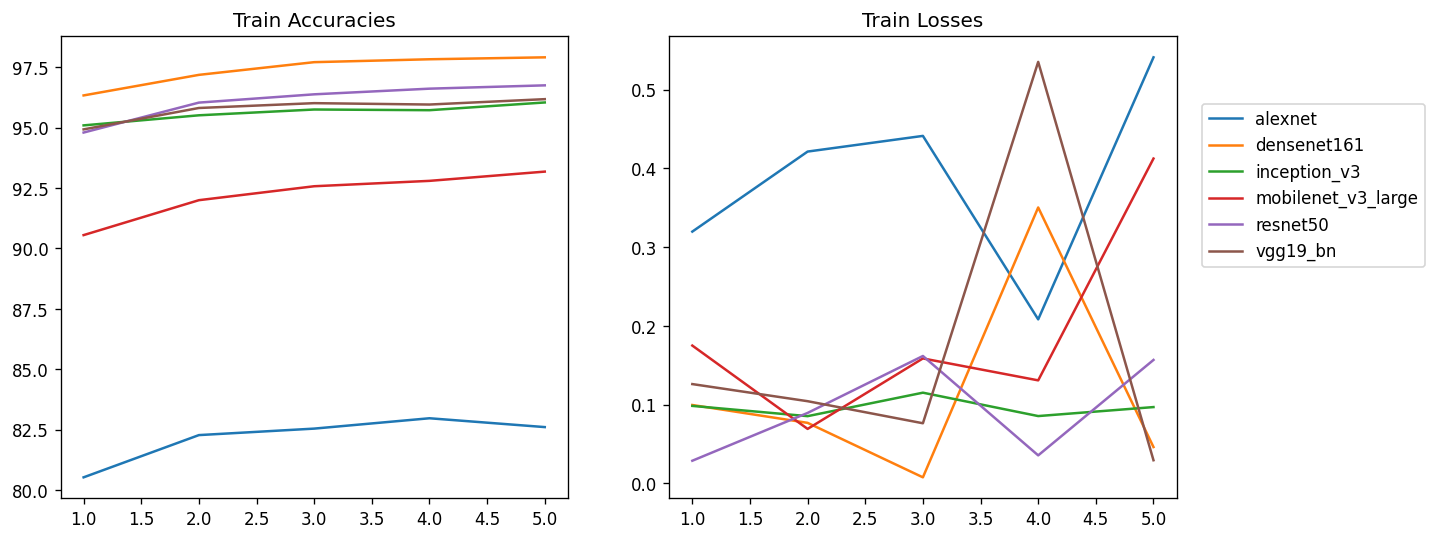

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=120)

for idx, accs in enumerate(model_train_accs):
    ax[0].plot(range(1, 6), accs, label=model_names[idx])
    
    ax[0].set_title("Train Accuracies")
    
    
for idx, losses in enumerate(model_train_losses):
    ax[1].plot(range(1, 6), losses, label=model_names[idx])
    
    ax[1].set_title("Train Losses")
    
    ax[1].legend(loc=(1.05,0.5))

## Test Accuracies

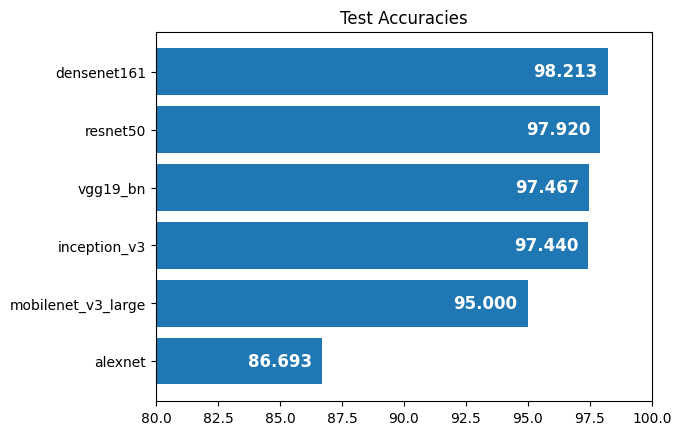

In [43]:
plt.figure()

test_acc_dict = {model_names[i]:model_test_accs[i] for i in range(len(model_test_accs))}
keys = list(test_acc_dict.keys())
values = list(test_acc_dict.values())


sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

plt.barh(list(sorted_dict.keys()), list(sorted_dict.values()))
plt.xlim(80,100)

plt.title("Test Accuracies")

for idx, value in enumerate(sorted_dict.values()):
    plt.text(value-3, idx, f"{value:.3f}", weight="bold", color="white", fontsize=12, va="center")

## Experiment Times (training and testing)

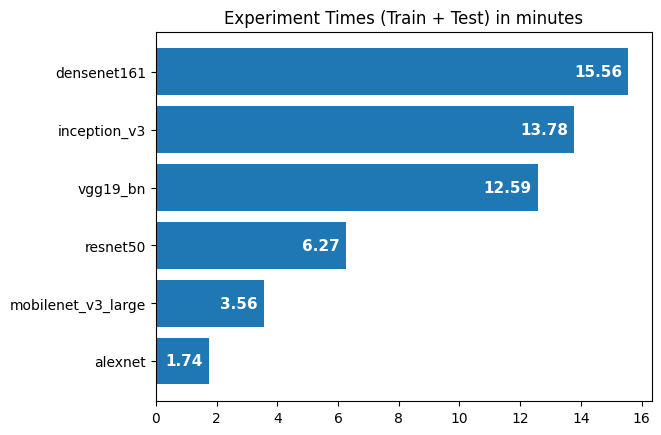

In [78]:
plt.figure()

exp_time_dict = {model_names[i]:experiment_times[i]/60 for i in range(len(experiment_times))}
keys = list(exp_time_dict.keys())
values = list(exp_time_dict.values())


sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

plt.barh(list(sorted_dict.keys()), list(sorted_dict.values()))


plt.title("Experiment Times (Train + Test) in minutes")


for idx, value in enumerate(sorted_dict.values()):
    plt.text(value-0.2, idx, f"{value:.2f}", weight="bold", fontsize=11, color="white", va="center", ha="right")

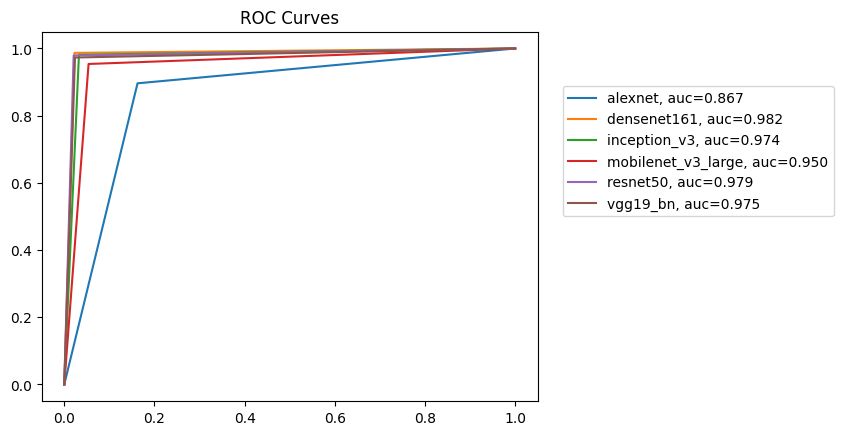

In [10]:
for idx, pred in enumerate(model_preds):
    fpr, tpr, _ = roc_curve(true_labels,  pred)
    auc = roc_auc_score(true_labels,  pred)
    plt.plot(fpr, tpr, label=f"{model_names[idx]}, auc={auc:.3f}")
    
plt.title("ROC Curves")
plt.legend(loc=(1.05,0.5))
plt.show()

## Classification Reports

In [89]:
for idx, m in enumerate(model_names):
    print(f"{m.upper()}:")
    print(classification_report(true_labels, model_preds[idx]))
    print("-"*53)

ALEXNET:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3748
           1       0.85      0.90      0.87      3752

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500

-----------------------------------------------------
DENSENET161:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3748
           1       0.98      0.99      0.98      3752

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500

-----------------------------------------------------
INCEPTION_V3:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3748
           1       0.97      0.98      0.97      3752

    accuracy                          